In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random
import numpy as np
from sklearn.linear_model import LinearRegression

## How do LIME's Parameters Work?

LIME trains local surrogate models to explain individual predictions. That explaination may or may not be helpful.

Local surrogate models with an added interpretability constraint can be expressed as follows:

$explanation(x) = \argmin\limits_{g \in G} L(f,g,π_x) + \Omega(g)$
<br>
\begin{array}{ll}
   g \in G & \text{Choose a model g from all possible models G} \\
   \argmin\limits_{g \in G} \bold{L}( ... ) & \text{that minimizes a loss for} \\
   \argmin\limits_{g \in G} L(\bold{f}, g, \pi_x ) & \text{predictions generated by the black box (f) on perturbed data points} \\
   \argmin\limits_{g \in G} L(f, g, \bold{\pi_x} ) & \text{where a prediction's weight depends on the distance kernel $\pi$ centered at x} \\
   \argmin\limits_{g \in G} L(f, g, \pi_x ) + \bold{\Omega(g)} & \text{and a regularizer penalizes more complex models} \\
\end{array}


In other words, this is how you train a local surrogate model:

1. Select the instance and corresponding black box prediction that you want an explanation of.
2. Perturb your dataset for new points and get the corresponding black box predictions.
3. Weight the new samples by their distance to the instance you chose.
4. Train an interpretable model on the weighted samples.
5. Interpret the local model as a proxy for the black box.

### Parameters in Practice: 2D Case

Visualizing a 2D case, a "black box" function maps x to y. We define it ourselves to see how accurate an explanation a local surrogate model can provide.

An interpretable local surrogate in this case is a line, and we can approximate the relationship between x and y by looking at the line's slope.

In [2]:
# Define our custom black box
def prediction_function(x):
    if (-5 < x) and (x <= 1):
        return (x+2)**2
    elif (x > 1):
        return -(1/10)*(x-1)**2 + 9
    
# Define the slope of the function we want our explanation's slope to match
def prediction_function_gradient(x): 
    # undefined at x=1
    if (-5 < x) and (x < 1):
        return 2*x
    elif (x == 1):
        return None
    elif (x > 1):
        return -(2/10)*x

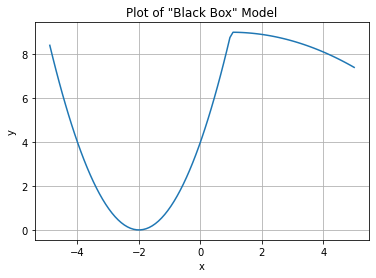

In [3]:
# Plot prediction function
# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate y values using the function
y = np.array([prediction_function(i) for i in x])

# Create the plot
plt.plot(x, y)
plt.title("""Plot of "Black Box" Model""")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

This is the function we'll be working with for this case. We could've chosen any function but this has three roughly linear sections to approximate, so a linear explainer has a chance to capture the black box function's behavior underneath.

Now we'll implement the steps of LIME to choose our explanations. (Let's skip 1 and choose our point of interest later)

#### Step 2: Perturb the dataset for new points

In [4]:
# Note: We don't need to worry about the complexity of this estimator because it is constrained to a single coefficient. So,
complexity = 1 #omega(g)
#[TODO] what would a more complex estimator look like?? quadratic?

# perturb the dataset across the entire space of possible values
# importance of the perturbations to the point of interest will be defined later by the exponential kernel
def generate_perturbed_predictions(num_perturbations, black_box):
    """
    Generates n perturbed data points and their black box predictions.

    Parameters:
        num_perturbations (int): Number of points to generate.
        black_box: model to approximate.

    Returns:
        array: contains the perturbations (x)
        array: contains the predictions (y)
    """
    perturbations = np.random.uniform(-5,5,num_perturbations)
    predictions = np.array([black_box(i) for i in perturbations])
    return perturbations, predictions


In [5]:
# Example Usage - Displaying first 5 values to be concise
num_perturbations = 50
perturbations, predictions = generate_perturbed_predictions(num_perturbations, prediction_function)
perturbations[:5], predictions[:5]

(array([-1.20612181,  1.87766087,  3.67093524, -0.55670653, -3.82413254]),
 array([0.63024258, 8.92297114, 8.28661049, 2.08309604, 3.32745951]))

#### Step 3: Weigh the New Samples
Like most LIME implementations do in practice, we'll use exponential smoothing to make closer samples matter more to the explaination.

Here's a great viz that shows how exponential smoothing works: https://miro.medium.com/v2/resize:fit:1400/1*kgd_wvYc5j80HTDDoafcmQ.gif

In [6]:
# Weigh the new samples according to their proximity - using exponential smoothing as LIME does

def exponential_kernel(x, x0, num_columns, kernel_width):
    """
    Computes the exponential smoothing kernel value for a given x and x0.

    Parameters:
        x (float): Input value.
        x0 (float): Center of the kernel.
        num_columns (int): Number of columns in the training data.

    Returns:
        float: Weight assigned by the exponential kernel.
    """
    # Compute kernel width
    h = kernel_width * np.sqrt(num_columns)
    #can update later to do sqrt(2) based on 2 dimensions for 3d example.
    
    # Compute the kernel value
    weight = np.exp(-np.abs(x - x0) / h)
    return weight


In [7]:
# Example Usage - Displaying first 5 values to be concise
point_of_interest = 2     # Center of the kernel
num_columns = 1  # Since we have 1 x in this example
kernel_width = 0.75

weighed_by_kernel = exponential_kernel(perturbations, point_of_interest, num_columns, kernel_width)
print(f"Kernel Weight: {weighed_by_kernel[:5]}")

Kernel Weight: [1.39144267e-02 8.49490226e-01 1.07753006e-01 3.30761752e-02
 4.24113246e-04]


### Step 4: Train a weighted, interpretable model

Use the weighted, perturbed points to fit the local surrogate.

In [8]:
def use_linear_surrogate(perturbations, predictions):
    """
    Fits a local linear surrogate and returns it and its predictions

    Parameters:
        perturbed_predictions(np.array, np.array): 
            Randomly chosen possible points (perturbations), Outputs of the "black box" for each perturbed point

    Returns:
        function: trained local surrogate model (sklearn linear regressor)
        array: the surrogate's approximations for the perturbed points
    """
    regr = LinearRegression()
    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature
    regr.fit(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), weighed_by_kernel)
    approximation_predictions = regr.predict(perturbations.reshape(-1, 1))
    return regr, approximation_predictions


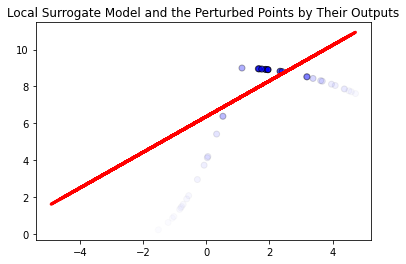

At x = 2
Predicted Slope: 0.967438526216395
Actual Slope:    -0.4


In [9]:
# Example Usage
regr, approximation_predictions = use_linear_surrogate(perturbations, predictions)
# plot the perturbed points
plt.scatter(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), color='blue', alpha=weighed_by_kernel, edgecolors='black', linewidths=1)
# plot the local surrogate
plt.plot(perturbations.reshape(-1, 1), approximation_predictions, color='red', linewidth=3, label='Weighted model')
plt.title("Local Surrogate Model and the Perturbed Points by Their Outputs")
plt.show()
# Print the difference between the estimated relationship and actual relationship x, y
print("At x = "+str(point_of_interest))
print("Predicted Slope: "+str(regr.coef_[0][0]))
print("Actual Slope:    "+str(prediction_function_gradient(point_of_interest)))

#### Step 5: Interpret the local surrogate

Use the following interactive visualization to play around with this example. Notice what happens when the point of interest, kernel width, and number of perturbations changes.

Visualization Key:
- Yellow Star - "Black Box" estimate for point of interest
- Black Line - "Black Box" model being approximated
- Blue Dots - "Black Box" predictions on perturbed points, Size is correlated with weight given by exponential kernel
- Red Line - Local Surrogate Model

In [ ]:
def lime_viz(point_of_interest, num_perturbations, perturbations, predictions, kernel_width=0.75, 
             black_box_function=prediction_function, prediction_function_gradient=prediction_function_gradient, 
             ymin=fixed(-1), ymax=fixed(10)):
    """
    Plots a visual representation of the local surrpogate process.

    Inputs:
        point_of_interest(float): black box point to approximate with the surrogate
        num_perturbations(int): number of perturbations to calculate
        perturbations: Perturbed points in the input space
        predictions: "Black box" outputs for perturbed inputs
        kernel_width: Size of the exponential kernel to use for weighing perturbations

    Returns:
        A visualization of the local surrogate, perturbed and weighted points, and "black box" model.
    """
    plt.clf()
    perturbations = perturbations[:num_perturbations]
    predictions = predictions[:num_perturbations]
    num_columns = 1 #for now working in 1D
    weighed_by_kernel = exponential_kernel(perturbations, point_of_interest, num_columns, kernel_width)

    regr = LinearRegression()
    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature
    regr.fit(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), weighed_by_kernel)
    approximation_predictions = regr.predict(perturbations.reshape(-1, 1))
    
    # Plot prediction function
    x = np.linspace(-5, 5, 100)
    y = np.array([black_box_function(i) for i in x])
    plt.plot(x, y, color='black', zorder=1)

    # Plot perturbed predictions
    plt.scatter(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), color='blue', s=weighed_by_kernel*1000, zorder=2)

    # Plot regression estimate
    plt.plot(perturbations.reshape(-1, 1), approximation_predictions, color='red', linewidth=3, label='Weighted model', zorder=3)

    # Plot point of interest
    plt.scatter(point_of_interest, black_box_function(point_of_interest), color='yellow', s=400, marker='*', edgecolors="black", zorder=4)

    print("Predicted Slope: "+str(regr.coef_[0][0]))
    print("Actual Slope:    "+str(prediction_function_gradient(point_of_interest)))
    #[TODO] Add slope difference

    plt.title("Plot of prediction_function")
    plt.xlim(-5,5)
    plt.ylim(ymin,ymax)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()
    

In [ ]:
max_perturbations = 100
perturbations, predictions = generate_perturbed_predictions(max_perturbations, prediction_function)
interact(lime_viz, point_of_interest=(-5,5,.5), 
            num_perturbations=(5,max_perturbations,5), 
            perturbations=fixed(perturbations), 
            predictions=fixed(predictions),
            kernel_width=(0.1,3,0.25),
            black_box_function=fixed(prediction_function),
            prediction_function_gradient=fixed(prediction_function_gradient)
        );


interactive(children=(FloatSlider(value=0.0, description='point_of_interest', max=5.0, min=-5.0, step=0.5), In…

### Can we expect a local surrogate model to be a good estimator?

As we can see above, the parameters have to be chosen appropriately for a surrogate to match the black box well.

At points of interest like $x=-2$ and $x=1$, the model doesn't do a good job at showing what's happening in the function

Beyond this, the local surrogate model has to have a good chance at capturing the model's behavior.

For example, a local surrogate model would have a difficult time explaining points on an oscilating function.

In [12]:
def oscilating_function(x):
    return np.sin(4*x) + 2
def oscilating_gradient(x):
    return 4*np.cos(4*x) 

In [ ]:
perturbations, predictions = generate_perturbed_predictions(max_perturbations, oscilating_function)
interact(lime_viz, point_of_interest=(-5,5,.5), 
            num_perturbations=(5,max_perturbations,5), 
            perturbations=fixed(perturbations), 
            predictions=fixed(predictions),
            kernel_width=(0.1,3,0.25),
            black_box_function=fixed(oscilating_function),
            prediction_function_gradient=fixed(oscilating_gradient),
            ymin=fixed(0),
            ymax=fixed(4)
        );

interactive(children=(FloatSlider(value=0.0, description='point_of_interest', max=5.0, min=-5.0, step=0.5), In…

In this case, unless the number of perturbations is large (100), and kernel width super small (0.1), we don't get a helpful estimate.

We were able to choose such a small kernel size to have an effective approximation only because we knew the underlying distribution. This suggests that in practice, choosing a standard kernel size may not give a good explanation of local behavior. Practitioners should experiment with a range of parameters to determine how stable an explanation is and whether the chosen region of explanation is appropriate.